# Posterior predictive checks for the speed of light data

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, pymc3 as pm, arviz as az, os, scipy as sp
from scipy import stats
import plot_tools

## Normal model

In [2]:
# From Aki Vehtari's demos
# data
data_path = os.path.abspath(
    os.path.join(
        os.path.curdir,
        'utilities_and_data',
        'light.txt'
    )
)
y = np.loadtxt(data_path)
#y = np.concatenate((y[:np.argmin(y)], y[np.argmin(y)+1:])) # Drop the lowest outlier, if desired
n = len(y)
s2 = np.var(y, ddof=1)  # Here ddof=1 is used to get the sample estimate.
s = np.sqrt(s2)
my = np.mean(y)

In [3]:
# scipy doesn't have the scaled inverse-chi-squared distribution, so we do the scale and inverse part ourselves
def get_sigma2(sd, n):
    x = sp.stats.chi2.rvs(n-1)
    y = 1/x
    y *= (n-1) * sd**2
    return y

# this is just a normal
def get_mu(ybar, sigma, n):
    return sp.stats.norm.rvs(ybar, sigma / np.sqrt(n))

In [4]:
def sample_posterior(ybar, sd, n):
    sigma2 = get_sigma2(sd, n)
    mu = get_mu(ybar, sigma2 ** (1/2), n)
    return (mu, sigma2)

def sample_posterior_predictive(ybar, sd, n):
    mu, sigma2 = sample_posterior(ybar, sd, n)
    return sp.stats.norm.rvs(mu, sigma2 ** 0.5)

In [5]:
replicates = np.array([[sample_posterior_predictive(my, s, n) for i in range(n)] for j in range(2000)])

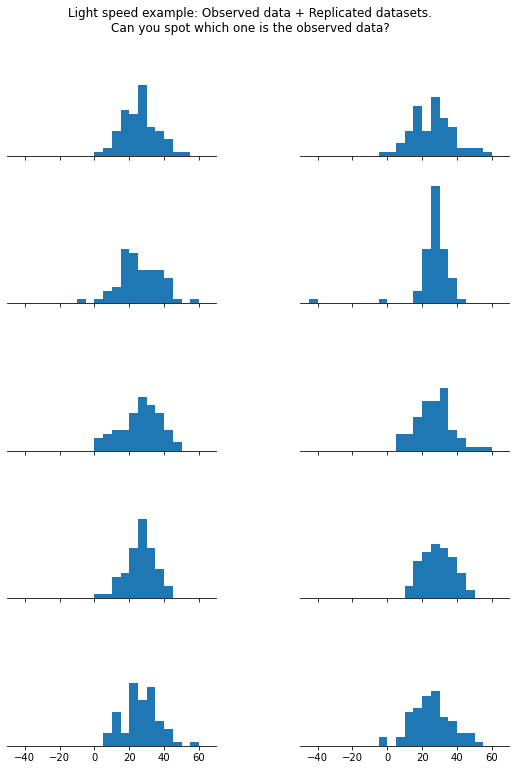

In [6]:
# plot them along with the real data set in random order subplot
fig, axes = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(9, 12))
fig.subplots_adjust(top=0.95, wspace=0.4)
order = np.random.permutation(10)
choices = np.random.permutation(2000)
for i, ax in enumerate(axes.flat):
    ax.hist(
        replicates[choices[order[i]]] if order[i] < 9 else y,
        np.arange(-45, 65, 5)
        #color = 'blue' if order[i] < 9 else 'red'
    )
    plot_tools.modify_axes.only_x(ax)
axes[0, 0].set_xlim([-50, 70])
fig.suptitle(
    "Light speed example: Observed data + Replicated datasets.\n"
    "Can you spot which one is the observed data?"
);

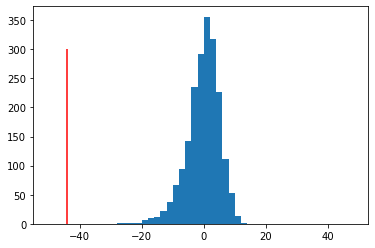

In [7]:
minimums = np.min(replicates, axis = 1)
plt.hist(minimums, bins=np.arange(-50, 50, 2))
plt.vlines(x=np.min(y), ymin=0, ymax=300, color = 'red')
plt.show()

In [8]:
# Normal model in PyMC3
with pm.Model() as model:
    mu = pm.Flat('mu')
    sigma_log = pm.Flat('sigma_log')
    sigma = pm.Deterministic('sigma', pm.math.exp(sigma_log))
    y_ = pm.Normal('y', mu = mu, sigma = sigma, observed = y)
    
    trace_norm = pm.sample(2000, return_inferencedata=True)
    
    replicates = pm.sample_posterior_predictive(trace_norm)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log, mu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.


## Student T model

In [9]:
# Student T Model
with pm.Model() as model:
    mu = pm.Flat('mu')
    sigma_log = pm.Flat('sigma_log')
    sigma = pm.Deterministic('sigma', pm.math.exp(sigma_log))
    y_ = pm.StudentT('y', nu = 3, mu = mu, sigma = sigma, observed = y)
    
    trace_t = pm.sample(2000, return_inferencedata=True)
    
    replicates = pm.sample_posterior_predictive(trace_t)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log, mu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.


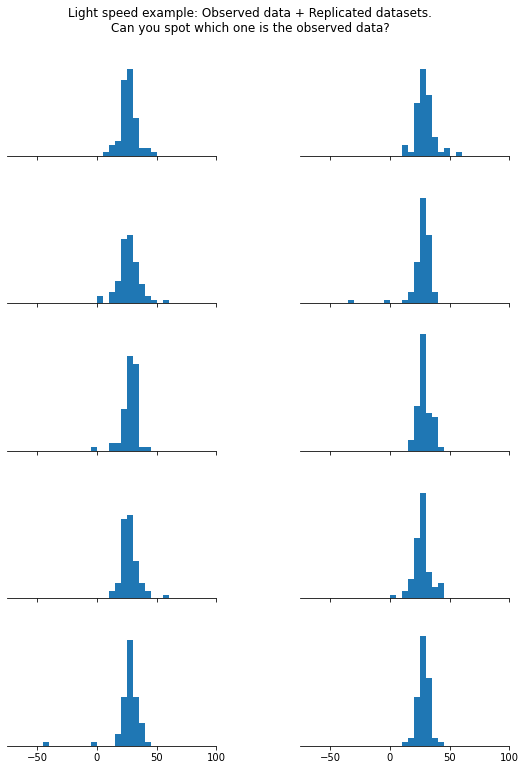

In [10]:
# plot them along with the real data set in random order subplot
fig, axes = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(9, 12))
fig.subplots_adjust(top=0.95, wspace=0.4)
#np.random.seed(824792)
order = np.random.permutation(10)
choices = np.random.permutation(2000)
for i, ax in enumerate(axes.flat):
    ax.hist(
        replicates['y'][choices[order[i]]] if order[i] < 9 else y,
        np.arange(-75, 100, 5)
    )
    plot_tools.modify_axes.only_x(ax)
axes[0, 0].set_xlim([-75, 100])
fig.suptitle(
    "Light speed example: Observed data + Replicated datasets.\n"
    "Can you spot which one is the observed data?"
);

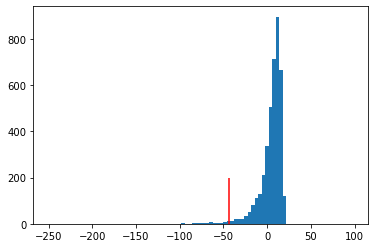

In [11]:
minimums = np.min(replicates['y'], axis = 1)
plt.hist(minimums, bins=np.arange(-250, 100, 4))
plt.vlines(x=np.min(y), ymin=0, ymax=200, color = 'red')
plt.show()

## Cauchy model

In [12]:
# Cauchy Model
with pm.Model() as model:
    beta = pm.HalfCauchy('beta', 5)
    alpha = pm.Normal('alpha', 0, 50)
    y_ = pm.Cauchy('y', alpha = alpha, beta = beta, observed = y)
    
    trace_cauchy = pm.sample(2000, return_inferencedata=True)
    
    replicates = pm.sample_posterior_predictive(trace_cauchy)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.


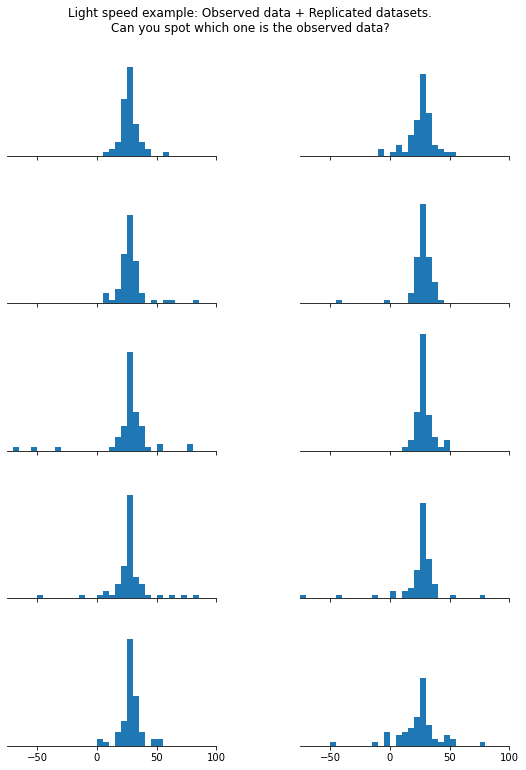

In [13]:
# plot them along with the real data set in random order subplot
fig, axes = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(9, 12))
fig.subplots_adjust(top=0.95, wspace=0.4)
order = np.random.permutation(10)
choices = np.random.permutation(2000)
for i, ax in enumerate(axes.flat):
    ax.hist(
        replicates['y'][choices[order[i]]] if order[i] < 9 else y,
        np.arange(-75, 100, 5)
    )
    plot_tools.modify_axes.only_x(ax)
axes[0, 0].set_xlim([-75, 100])
fig.suptitle(
    "Light speed example: Observed data + Replicated datasets.\n"
    "Can you spot which one is the observed data?"
);

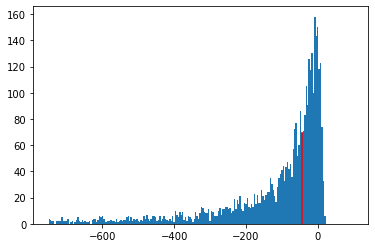

In [14]:
minimums = np.min(replicates['y'], axis = 1)
plt.hist(minimums, bins=np.arange(-750, 100, 4))
plt.vlines(x=np.min(y), ymin=0, ymax=70, color = 'red')
plt.show()

In [15]:
az.compare({'normal':trace_norm, 'studentt':trace_t, 'cauchy':trace_cauchy}, ic='loo')

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
studentt,0,-218.012915,2.066822,0.000000,0.818228,11.412499,0.000000,False,log
cauchy,1,-220.845212,2.047360,2.832298,0.181772,9.259205,3.777416,False,log
normal,2,-259.274579,13.605664,41.261664,0.000000,29.150316,21.060734,True,log


In [20]:
az.loo(trace_norm, pointwise = True)

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 by 66 log-likelihood matrix

         Estimate       SE
elpd_loo  -259.27    29.15
p_loo       13.61        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       65   98.5%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    1    1.5%